# 🎨 3W Dataset Visualization Techniques

This notebook demonstrates advanced visualization techniques for the 3W oil well dataset using dimensionality reduction methods and statistical analysis.

**Key Features:**
- **t-SNE & UMAP**: Dimensionality reduction for pattern discovery with parameter optimization
- **Smart class mapping**: Transient states consolidated with base fault classes
- **Balanced sampling**: Focused analysis on fault classes (1-9, excluding normal operation)
- **Interactive dashboards**: Multi-plot analysis with statistical insights
- **Feature analysis**: Sensor relationships and discriminative power analysis
- **Performance optimization**: Fast loading with pickle format

**Prerequisites:**
- Run `1_data_treatment.ipynb` first to generate windowed time series data
- Ensure processed data is saved in pickle format for optimal performance

In [1]:
# ============================================================
# LOAD 3W DATASET FOR VISUALIZATION ANALYSIS
# ============================================================
import time
import sys
import os

start_time = time.time()

print("🎨 Loading 3W Dataset for Visualization Analysis")
print("=" * 60)

# Import configuration and validate
print("📦 Setting up environment...")
sys.path.append("src")

try:
    print("   • Importing modules...", end=" ", flush=True)
    from src.data_persistence import DataPersistence
    from src import config
    import pandas as pd
    import numpy as np
    print("✅")
    
    # Validate configuration
    print("   • Validating configuration...", end=" ", flush=True)
    if hasattr(config, 'validate_config'):
        warnings = config.validate_config()
        if warnings:
            print("⚠️")
            print("     Configuration warnings:")
            for warning in warnings:
                print(f"       • {warning}")
        else:
            print("✅")
    else:
        print("✅")
    
    print("   • Initializing data persistence...", end=" ", flush=True)
    persistence = DataPersistence(base_dir=config.PROCESSED_DATA_DIR, verbose=False)
    print("✅")

    print(f"   • Save format: {config.SAVE_FORMAT}")
    print(f"   • Expected directory: {config.PROCESSED_DATA_DIR}")

    # Check windowed directory
    windowed_dir = os.path.join(persistence.cv_splits_dir, "windowed")
    print(f"\n📁 Checking data availability...")
    print(f"   • Windowed directory: {windowed_dir}")
    print(f"   • Directory exists: ", end="", flush=True)

    if not os.path.exists(windowed_dir):
        print("❌")
        print("\nERROR: Run '1_data_treatment.ipynb' first to generate windowed data")
        raise FileNotFoundError("No windowed data directory found.")
    
    print("✅")

    # Look for fold directories
    print("   • Scanning for fold directories...", end=" ", flush=True)
    try:
        fold_dirs = [
            d for d in os.listdir(windowed_dir)
            if d.startswith("fold_") and os.path.isdir(os.path.join(windowed_dir, d))
        ]
        fold_dirs.sort()
        print(f"✅ Found {len(fold_dirs)} folds")
        
        if fold_dirs:
            print(f"     Available folds: {', '.join(fold_dirs)}")
        else:
            raise FileNotFoundError("No fold directories found in windowed data.")
            
    except Exception as e:
        print(f"❌ Error listing directory: {e}")
        raise

    # Load data from the first fold
    first_fold_dir = fold_dirs[0]
    fold_path = os.path.join(windowed_dir, first_fold_dir)
    fold_num = first_fold_dir.replace("fold_", "")

    print(f"\n📊 Loading data from {first_fold_dir}...")
    print(f"   • Fold path: {fold_path}")

    # Check available files
    print("   • Checking available files...", end=" ", flush=True)
    try:
        available_files = os.listdir(fold_path)
        print(f"✅ Found {len(available_files)} files")
    except Exception as e:
        print(f"❌ Cannot list fold directory: {e}")
        raise

    # Load data with fallback options
    data_files = {
        'pickle': os.path.join(fold_path, f"test_windowed.{config.SAVE_FORMAT}"),
        'parquet': os.path.join(fold_path, "test_windowed.parquet")
    }

    print(f"\n🔄 Loading test data...")
    load_start = time.time()
    test_dfs, test_classes = None, None
    loaded_format = None

    # Try pickle first, then parquet
    for format_name, file_path in data_files.items():
        print(f"   • Trying {format_name} format: {os.path.basename(file_path)}...", end=" ", flush=True)
        
        if os.path.exists(file_path):
            print("file found, loading...", end=" ", flush=True)
            try:
                if format_name == 'pickle':
                    test_dfs, test_classes = persistence._load_dataframes(file_path, config.SAVE_FORMAT)
                else:
                    test_dfs, test_classes = persistence._load_from_parquet(file_path)
                
                loaded_format = format_name
                load_time = time.time() - load_start
                print(f"✅ ({load_time:.3f}s)")
                break
                
            except Exception as e:
                print(f"❌ Failed: {str(e)[:50]}...")
                continue
        else:
            print("❌ File not found")

    if test_dfs is None:
        print(f"\n❌ FAILED TO LOAD DATA")
        print(f"   • No compatible test data file found in: {fold_path}")
        print(f"   • Expected files: test_windowed.pickle or test_windowed.parquet")
        raise FileNotFoundError("No compatible test data file found")

    # Validation and summary
    print(f"\n✅ DATA LOADING SUCCESSFUL!")
    print(f"   • Format used: {loaded_format}")
    print(f"   • Fold: {fold_num}")
    print(f"   • Windows loaded: {len(test_dfs)}")
    print(f"   • Load time: {load_time:.3f}s")

    if test_dfs and len(test_dfs) > 0:
        first_test_window = test_dfs[0]
        first_test_class = test_classes[0] if test_classes else "Unknown"
        
        print(f"\n🪟 Sample Window Analysis:")
        print(f"   • Shape: {first_test_window.shape}")
        print(f"   • Class: {first_test_class}")
        print(f"   • Columns: {list(first_test_window.columns)}")

        total_time = time.time() - start_time
        print(f"\n⚡ Performance Summary:")
        print(f"   • Total setup time: {total_time:.3f}s")
        print(f"   • Data loading time: {load_time:.3f}s")

        print(f"\n🎯 Ready for Visualization Analysis!")
        print(f"   • Dataset size: {len(test_dfs)} windowed time series")
        print(f"   • Window dimensions: {first_test_window.shape}")

    else:
        print(f"\n⚠️ Warning: No test windows found in the loaded data")

except Exception as e:
    print(f"\n❌ ERROR: {e}")
    print(f"\nTroubleshooting:")
    print(f"   • Check if '1_data_treatment.ipynb' completed successfully")
    print(f"   • Verify processed_data directory exists")
    print(f"   • Ensure windowed data was saved properly")

    if 'config' in locals():
        expected_dir = getattr(config, 'PROCESSED_DATA_DIR', 'Not configured')
        print(f"\nDiagnostic Information:")
        print(f"   • Expected base directory: {expected_dir}")
        
        if expected_dir != 'Not configured' and os.path.exists(expected_dir):
            try:
                contents = os.listdir(expected_dir)
                print(f"   • Contents: {contents}")
            except Exception as list_error:
                print(f"   • Cannot list contents: {list_error}")

    test_dfs, test_classes = None, None
    
    import traceback
    traceback.print_exc()

🎨 Loading 3W Dataset for Visualization Analysis
📦 Setting up environment...
   • Importing modules... ✅
   • Validating configuration... ✅
   • Initializing data persistence... ✅
   • Save format: pickle
   • Expected directory: processed_data

📁 Checking data availability...
   • Windowed directory: processed_data\cv_splits\windowed
   • Directory exists: ✅
   • Scanning for fold directories... ✅ Found 3 folds
     Available folds: fold_1, fold_2, fold_3

📊 Loading data from fold_1...
   • Fold path: processed_data\cv_splits\windowed\fold_1
   • Checking available files... ✅ Found 3 files

🔄 Loading test data...
   • Trying pickle format: test_windowed.pickle... file found, loading... ✅
   • Validating configuration... ✅
   • Initializing data persistence... ✅
   • Save format: pickle
   • Expected directory: processed_data

📁 Checking data availability...
   • Windowed directory: processed_data\cv_splits\windowed
   • Directory exists: ✅
   • Scanning for fold directories... ✅ Found 

In [2]:
# ============================================================
# DATA PREPARATION FOR DIMENSIONALITY REDUCTION
# ============================================================

print("🔧 Preparing Data for Dimensionality Reduction")
print("=" * 60)

# Validate data availability from previous cell
if 'test_dfs' not in locals() or test_dfs is None or len(test_dfs) == 0:
    print("❌ No test data available. Please run the previous cell first to load data.")
    X_scaled, y_labels = None, None
else:
    try:
        # Import required libraries
        print("📦 Loading visualization libraries...", end=" ")
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.preprocessing import StandardScaler
        from sklearn.manifold import TSNE
        import warnings
        warnings.filterwarnings("ignore")
        print("✅")

        # Install and import UMAP
        try:
            import umap
            print("✅ UMAP already available")
        except ImportError:
            print("📦 Installing UMAP-learn...", end=" ")
            import subprocess
            import sys
            try:
                subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"], 
                                     capture_output=True, text=True)
                import umap
                print("✅")
            except Exception as e:
                print(f"❌ UMAP installation failed: {e}")
                print("⚠️  Continuing without UMAP (only t-SNE will be available)")
                umap = None

        # Process windowed data
        print("📊 Processing windowed data for visualization...")
        print(f"🪟 Available windows: {len(test_dfs)}")
        print(f"📋 Window shape example: {test_dfs[0].shape}")

        # Extract class labels
        print("🏷️ Extracting and validating class labels...", end=" ")
        window_classes = []
        
        for i, window_df in enumerate(test_dfs):
            if "class" in window_df.columns:
                window_class = window_df["class"].iloc[-1]
                if window_df["class"].nunique() > 1:
                    print(f"⚠️  Warning: Inconsistent classes in window {i}")
                window_classes.append(window_class)
            else:
                if i < len(test_classes):
                    window_classes.append(test_classes[i])
                else:
                    print(f"❌ Missing class for window {i}")
                    window_classes.append(0)
        print("✅")

        print(f"🏷️ Original class distribution: {dict(zip(*np.unique(window_classes, return_counts=True)))}")

        # Map transient classes to base classes
        print("🔄 Mapping transient classes to base classes...", end=" ")
        transient_mapping = {101: 1, 102: 2, 105: 5, 106: 6, 107: 7, 108: 8, 109: 9}

        mapped_classes = []
        transient_count = 0
        for cls in window_classes:
            if cls in transient_mapping:
                mapped_classes.append(transient_mapping[cls])
                transient_count += 1
            else:
                mapped_classes.append(cls)
        
        print(f"✅ (mapped {transient_count} transient classes)")
        print(f"🏷️ Mapped class distribution: {dict(zip(*np.unique(mapped_classes, return_counts=True)))}")

        # Intelligent sampling
        print("🎯 Intelligent sampling for visualization...", end=" ")
        
        # Get target classes from config, fallback to 1-9
        if hasattr(config, 'CLASSIFICATION_CONFIG') and 'selected_classes' in config.CLASSIFICATION_CONFIG:
            target_classes = config.CLASSIFICATION_CONFIG["selected_classes"]
        else:
            target_classes = list(range(1, 10))
        
        MAX_SAMPLES_PER_CLASS = getattr(config, 'VISUALIZATION_MAX_SAMPLES', 50)
        
        selected_indices = []
        selected_classes = []
        sampling_summary = {}

        np.random.seed(42)
        
        for target_class in target_classes:
            class_indices = [i for i, cls in enumerate(mapped_classes) if cls == target_class]
            
            if len(class_indices) > 0:
                n_samples = min(MAX_SAMPLES_PER_CLASS, len(class_indices))
                sampled_indices = np.random.choice(class_indices, size=n_samples, replace=False)
                selected_indices.extend(sampled_indices)
                selected_classes.extend([target_class] * len(sampled_indices))
                sampling_summary[target_class] = {
                    'available': len(class_indices),
                    'sampled': n_samples
                }

        print("✅")

        # Sampling report
        print(f"📊 Sampling Summary (max {MAX_SAMPLES_PER_CLASS} per class):")
        for cls, stats in sampling_summary.items():
            ratio = stats['sampled'] / stats['available'] * 100
            print(f"   • Class {cls}: {stats['sampled']}/{stats['available']} windows ({ratio:.1f}%)")

        # Filter selected data
        selected_test_dfs = [test_dfs[i] for i in selected_indices]
        selected_window_classes = selected_classes

        print(f"🎯 Selected {len(selected_indices)} windows for analysis")
        print(f"🏷️ Final distribution: {dict(zip(*np.unique(selected_window_classes, return_counts=True)))}")

        # Feature extraction
        print("🔄 Extracting and flattening features...", end=" ")
        flattened_windows = []
        feature_columns = None

        for i, window_df in enumerate(selected_test_dfs):
            if feature_columns is None:
                feature_columns = [col for col in window_df.columns if col != "class"]
                print(f"\n   📊 Feature columns detected: {feature_columns}")
                print(f"   🔧 Features per window: {len(feature_columns)} sensors × {window_df.shape[0]} timesteps = {len(feature_columns) * window_df.shape[0]} total features")

            try:
                flattened = window_df[feature_columns].values.flatten()
                flattened_windows.append(flattened)
            except Exception as e:
                print(f"❌ Error processing window {i}: {e}")
                continue

        # Convert to numpy arrays
        if flattened_windows:
            X_scaled = np.array(flattened_windows)
            y_labels = np.array(selected_window_classes[:len(flattened_windows)])
            
            # Validate array shapes
            if X_scaled.shape[0] != y_labels.shape[0]:
                print(f"⚠️  Shape mismatch: X_scaled {X_scaled.shape}, y_labels {y_labels.shape}")
                min_samples = min(X_scaled.shape[0], y_labels.shape[0])
                X_scaled = X_scaled[:min_samples]
                y_labels = y_labels[:min_samples]
                
            print("✅")
            
            # Apply standardization
            print("🔧 Applying standardization...", end=" ")
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_scaled)
            print("✅")

            # Summary
            print(f"\n📈 Feature Matrix Summary:")
            print(f"   • Samples: {X_scaled.shape[0]} (balanced across {len(np.unique(y_labels))} classes)")
            print(f"   • Features: {X_scaled.shape[1]} (standardized)")
            print(f"   • Classes: {sorted(np.unique(y_labels))}")
            print(f"   • Memory usage: {X_scaled.nbytes / 1024 / 1024:.2f} MB")

            if len(feature_columns) > 0:
                expected_features = selected_test_dfs[0].shape[0] * len(feature_columns)
                print(f"   • Feature validation: {X_scaled.shape[1]} = {expected_features} ✅")

        else:
            print("❌ No valid windows processed")
            X_scaled, y_labels = None, None

    except Exception as e:
        print(f"❌ Error during data preparation: {e}")
        X_scaled, y_labels = None, None
        
        import traceback
        print(f"\nDetailed error:")
        traceback.print_exc()

🔧 Preparing Data for Dimensionality Reduction
📦 Loading visualization libraries... ✅
✅ UMAP already available
📊 Processing windowed data for visualization...
🪟 Available windows: 10217
📋 Window shape example: (300, 4)
🏷️ Extracting and validating class labels... ✅ UMAP already available
📊 Processing windowed data for visualization...
🪟 Available windows: 10217
📋 Window shape example: (300, 4)
🏷️ Extracting and validating class labels... ⚠️  Warning: Inconsistent classes in window 3438
⚠️  Warning: Inconsistent classes in window 3439
⚠️  Warning: Inconsistent classes in window 3451
⚠️  Warning: Inconsistent classes in window 3452
⚠️  Warning: Inconsistent classes in window 3462
⚠️  Warning: Inconsistent classes in window 3463
⚠️  Warning: Inconsistent classes in window 3471
⚠️  Warning: Inconsistent classes in window 3472
⚠️  Warning: Inconsistent classes in window 3547
⚠️  Warning: Inconsistent classes in window 3548
⚠️  Warning: Inconsistent classes in window 3599
⚠️  Warning: Inconsi

🎯 t-SNE: Visualization of 3W Dataset Features
🔮 Running t-SNE analysis on 292 windows with 900 features...
📊 Classes to visualize: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(8)]
🔄 t-SNE #1: perplexity=5, lr=auto... ✅ (5.7s, KL=0.388)
🔄 t-SNE #2: perplexity=30, lr=auto... ✅ (5.7s, KL=0.388)
🔄 t-SNE #2: perplexity=30, lr=auto... ✅ (0.6s, KL=0.293)
🔄 t-SNE #3: perplexity=50, lr=200... ✅ (0.6s, KL=0.293)
🔄 t-SNE #3: perplexity=50, lr=200... ✅ (0.5s, KL=0.258)
🔄 t-SNE #4: perplexity=15, lr=50... ✅ (0.5s, KL=0.258)
🔄 t-SNE #4: perplexity=15, lr=50... ✅ (0.5s, KL=0.323)
✅ (0.5s, KL=0.323)


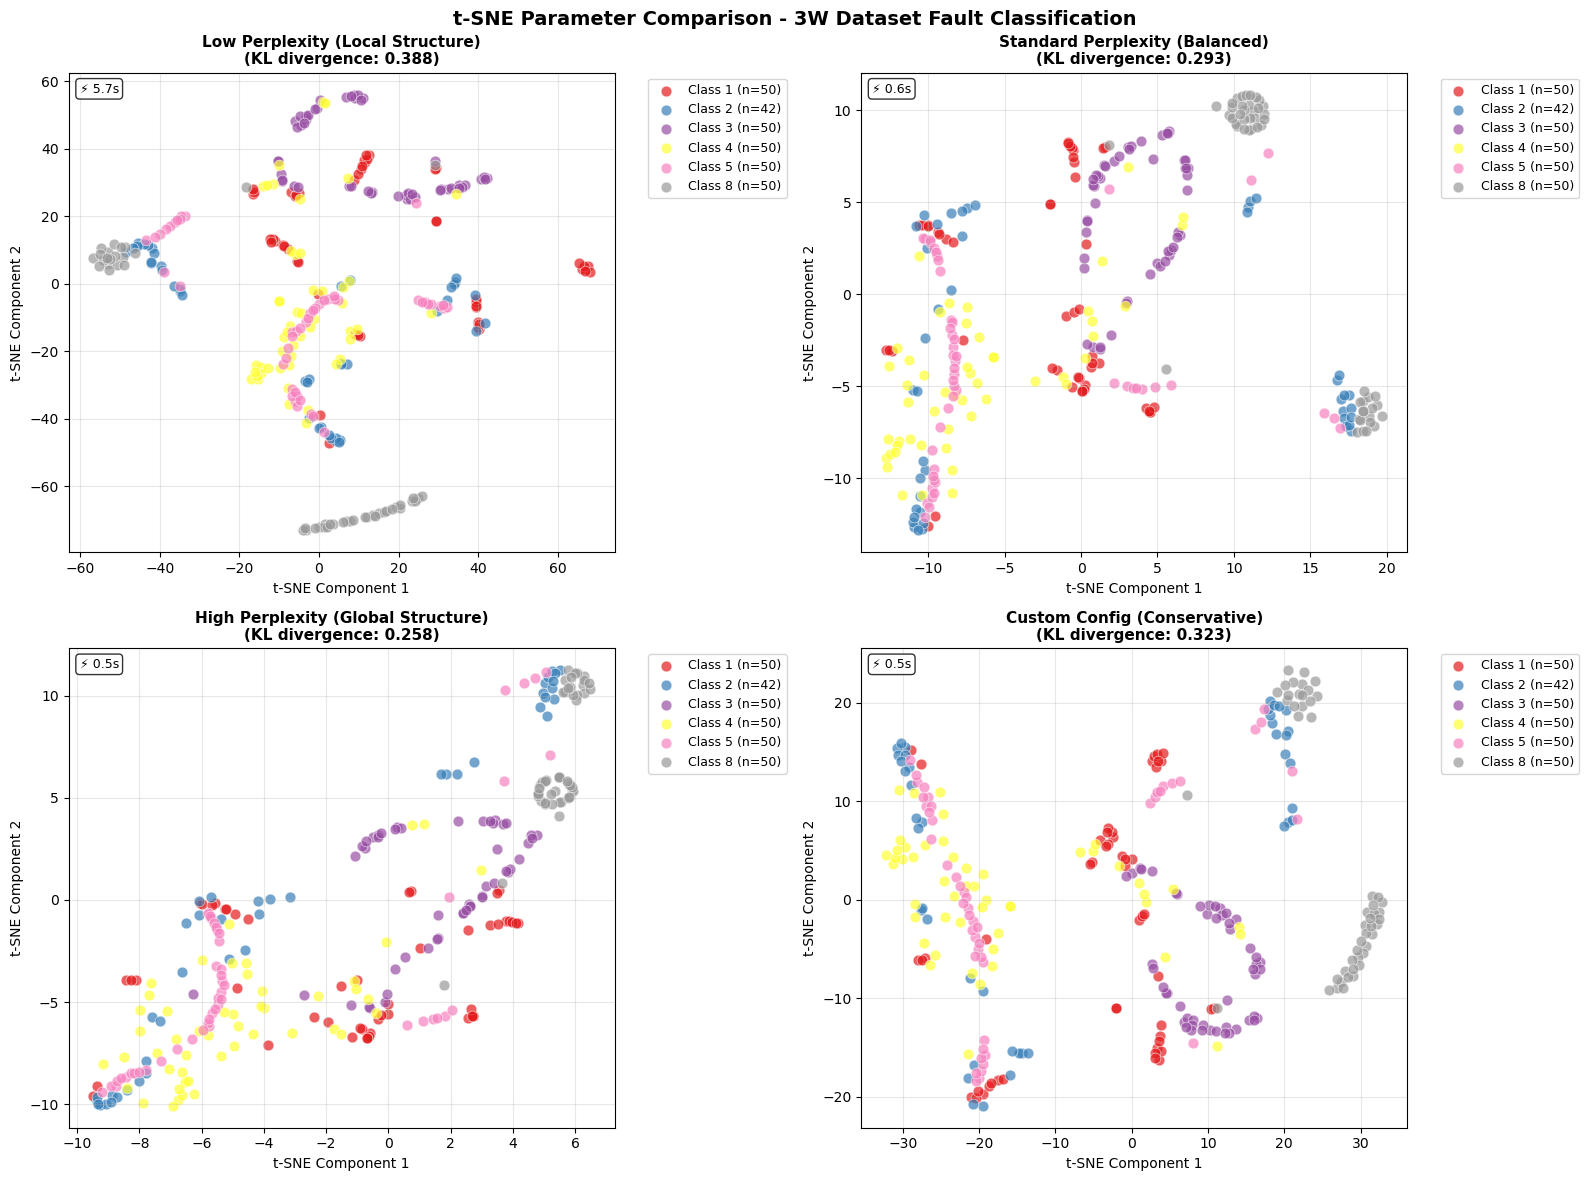


📊 t-SNE Analysis Results:
   • Total windows visualized: 292
   • Feature dimensions: 900 → 2D
   • Classes analyzed: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(8)]

⚡ Performance Comparison:
   • Config 1: 5.7s, KL=0.388
   • Config 2: 0.6s, KL=0.293
   • Config 3: 0.5s, KL=0.258 🏆 Best Quality ⚡ Fastest
   • Config 4: 0.5s, KL=0.323

🎯 Class Separation Analysis:
   • Class 1: 50 windows (17.1%)
   • Class 2: 42 windows (14.4%)
   • Class 3: 50 windows (17.1%)
   • Class 4: 50 windows (17.1%)
   • Class 5: 50 windows (17.1%)
   • Class 8: 50 windows (17.1%)


In [3]:
# ============================================================
# t-SNE VISUALIZATION WITH PARAMETER OPTIMIZATION
# ============================================================

if X_scaled is not None and y_labels is not None:
    print("🎯 t-SNE: Visualization of 3W Dataset Features")
    print("=" * 60)

    # Set up plotting parameters
    plt.style.use("default")
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    # Color mapping
    unique_classes = np.unique(y_labels)
    colors = plt.cm.Set1(np.linspace(0, 1, len(unique_classes)))
    class_colors = {cls: colors[i] for i, cls in enumerate(unique_classes)}

    print(f"🔮 Running t-SNE analysis on {X_scaled.shape[0]} windows with {X_scaled.shape[1]} features...")
    print(f"📊 Classes to visualize: {list(unique_classes)}")

    # Multiple t-SNE configurations
    tsne_configs = [
        {"perplexity": 5, "learning_rate": "auto", "title": "Low Perplexity (Local Structure)"},
        {"perplexity": 30, "learning_rate": "auto", "title": "Standard Perplexity (Balanced)"},
        {"perplexity": min(50, X_scaled.shape[0]//3), "learning_rate": 200, "title": "High Perplexity (Global Structure)"},
        {"perplexity": 15, "learning_rate": 50, "title": "Custom Config (Conservative)"}
    ]

    tsne_results = []
    
    for idx, config in enumerate(tsne_configs):
        if idx >= len(axes):
            break
            
        print(f"🔄 t-SNE #{idx+1}: perplexity={config['perplexity']}, lr={config['learning_rate']}...", end=" ")
        
        try:
            # Create t-SNE instance
            tsne = TSNE(
                n_components=2,
                perplexity=min(config["perplexity"], X_scaled.shape[0]//4),
                learning_rate=config["learning_rate"],
                n_iter=1000,
                random_state=42,
                init="pca",
                method="barnes_hut",
                early_exaggeration=12.0,
                metric="euclidean"
            )

            # Fit and transform
            start_time = time.time()
            X_tsne = tsne.fit_transform(X_scaled)
            elapsed_time = time.time() - start_time
            
            # Store results
            tsne_results.append({
                'embedding': X_tsne,
                'config': config,
                'time': elapsed_time,
                'kl_divergence': tsne.kl_divergence_
            })
            
            print(f"✅ ({elapsed_time:.1f}s, KL={tsne.kl_divergence_:.3f})")

            # Plot
            ax = axes[idx]
            
            # Plot each class
            for class_label in unique_classes:
                mask = y_labels == class_label
                class_points = X_tsne[mask]
                
                ax.scatter(
                    class_points[:, 0],
                    class_points[:, 1],
                    c=[class_colors[class_label]],
                    label=f"Class {class_label} (n={np.sum(mask)})",
                    alpha=0.7,
                    s=60,
                    edgecolors='white',
                    linewidth=0.5
                )

            # Styling
            ax.set_title(f"{config['title']}\n(KL divergence: {tsne.kl_divergence_:.3f})", 
                        fontsize=11, fontweight="bold")
            ax.set_xlabel("t-SNE Component 1")
            ax.set_ylabel("t-SNE Component 2")
            ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
            ax.grid(True, alpha=0.3)
            
            # Performance annotation
            ax.text(0.02, 0.98, f"⚡ {elapsed_time:.1f}s", 
                   transform=ax.transAxes, fontsize=9, 
                   verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

        except Exception as e:
            print(f"❌ Error: {e}")
            ax = axes[idx]
            ax.text(0.5, 0.5, f"t-SNE Failed\n{str(e)}", 
                   horizontalalignment='center', verticalalignment='center',
                   transform=ax.transAxes, fontsize=12, color='red')
            ax.set_title(f"{config['title']} - Failed", fontsize=11)

    plt.suptitle("t-SNE Parameter Comparison - 3W Dataset Fault Classification", 
                fontsize=14, fontweight="bold", y=0.98)
    plt.tight_layout()
    plt.show()

    # Analysis results
    print("\n📊 t-SNE Analysis Results:")
    print(f"   • Total windows visualized: {X_scaled.shape[0]}")
    print(f"   • Feature dimensions: {X_scaled.shape[1]} → 2D")
    print(f"   • Classes analyzed: {list(unique_classes)}")
    
    if tsne_results:
        print(f"\n⚡ Performance Comparison:")
        best_config = min(tsne_results, key=lambda x: x['kl_divergence'])
        fastest_config = min(tsne_results, key=lambda x: x['time'])
        
        for i, result in enumerate(tsne_results):
            status = ""
            if result['kl_divergence'] == best_config['kl_divergence']:
                status += " 🏆 Best Quality"
            if result['time'] == fastest_config['time']:
                status += " ⚡ Fastest"
                
            print(f"   • Config {i+1}: {result['time']:.1f}s, KL={result['kl_divergence']:.3f}{status}")

    # Class separation analysis
    print(f"\n🎯 Class Separation Analysis:")
    class_stats = {}
    for class_label in unique_classes:
        count = np.sum(y_labels == class_label)
        percentage = (count / len(y_labels)) * 100
        class_stats[class_label] = {'count': count, 'percentage': percentage}
        print(f"   • Class {class_label}: {count} windows ({percentage:.1f}%)")

else:
    print("❌ Cannot run t-SNE analysis: No processed data available")
    print("Please ensure the data preparation cell completed successfully")

In [4]:
# ============================================================
# ANALYSIS RESULTS VALIDATION
# ============================================================

# Validate and display analysis results
print("🔧 Validating analysis results...")

# Display t-SNE results if available
if 'tsne_results' in locals() and tsne_results:
    print("✅ t-SNE results available")
    
    print(f"\n⚡ t-SNE Performance Summary:")
    best_kl = min(result['kl_divergence'] for result in tsne_results)
    fastest_time = min(result['time'] for result in tsne_results)
    
    for i, result in enumerate(tsne_results):
        status = ""
        if abs(result['kl_divergence'] - best_kl) < 1e-6:
            status += " 🏆 Best Quality"
        if abs(result['time'] - fastest_time) < 1e-6:
            status += " ⚡ Fastest"
            
        print(f"   • Config {i+1}: {result['time']:.1f}s, KL={result['kl_divergence']:.3f}{status}")

# Display UMAP results if available
if 'umap_results' in locals() and umap_results:
    print(f"\n🚀 UMAP Performance Summary:")
    fastest_umap_time = min(result['time'] for result in umap_results)
    
    for i, result in enumerate(umap_results):
        status = ""
        if abs(result['time'] - fastest_umap_time) < 1e-6:
            status += " ⚡ Fastest"
            
        print(f"   • Config {i+1}: {result['time']:.1f}s{status}")

print(f"\n✅ Analysis validation complete")

🔧 Validating analysis results...
✅ t-SNE results available

⚡ t-SNE Performance Summary:
   • Config 1: 5.7s, KL=0.388
   • Config 2: 0.6s, KL=0.293
   • Config 3: 0.5s, KL=0.258 🏆 Best Quality ⚡ Fastest
   • Config 4: 0.5s, KL=0.323

✅ Analysis validation complete


🚀 UMAP: Dimensionality Reduction Analysis
🔮 Running UMAP analysis on 292 windows...
🔄 UMAP #1: neighbors=15, dist=0.1, euclidean... ✅ (10.7s)
🔄 UMAP #2: neighbors=5, dist=0.0, euclidean... ✅ (0.2s)
🔄 UMAP #3: neighbors=50, dist=0.5, cosine... ✅ (10.7s)
🔄 UMAP #2: neighbors=5, dist=0.0, euclidean... ✅ (0.2s)
🔄 UMAP #3: neighbors=50, dist=0.5, cosine... ✅ (0.5s)
🔄 UMAP #4: neighbors=30, dist=0.25, manhattan... ✅ (0.5s)
🔄 UMAP #4: neighbors=30, dist=0.25, manhattan... ✅ (0.4s)
✅ (0.4s)


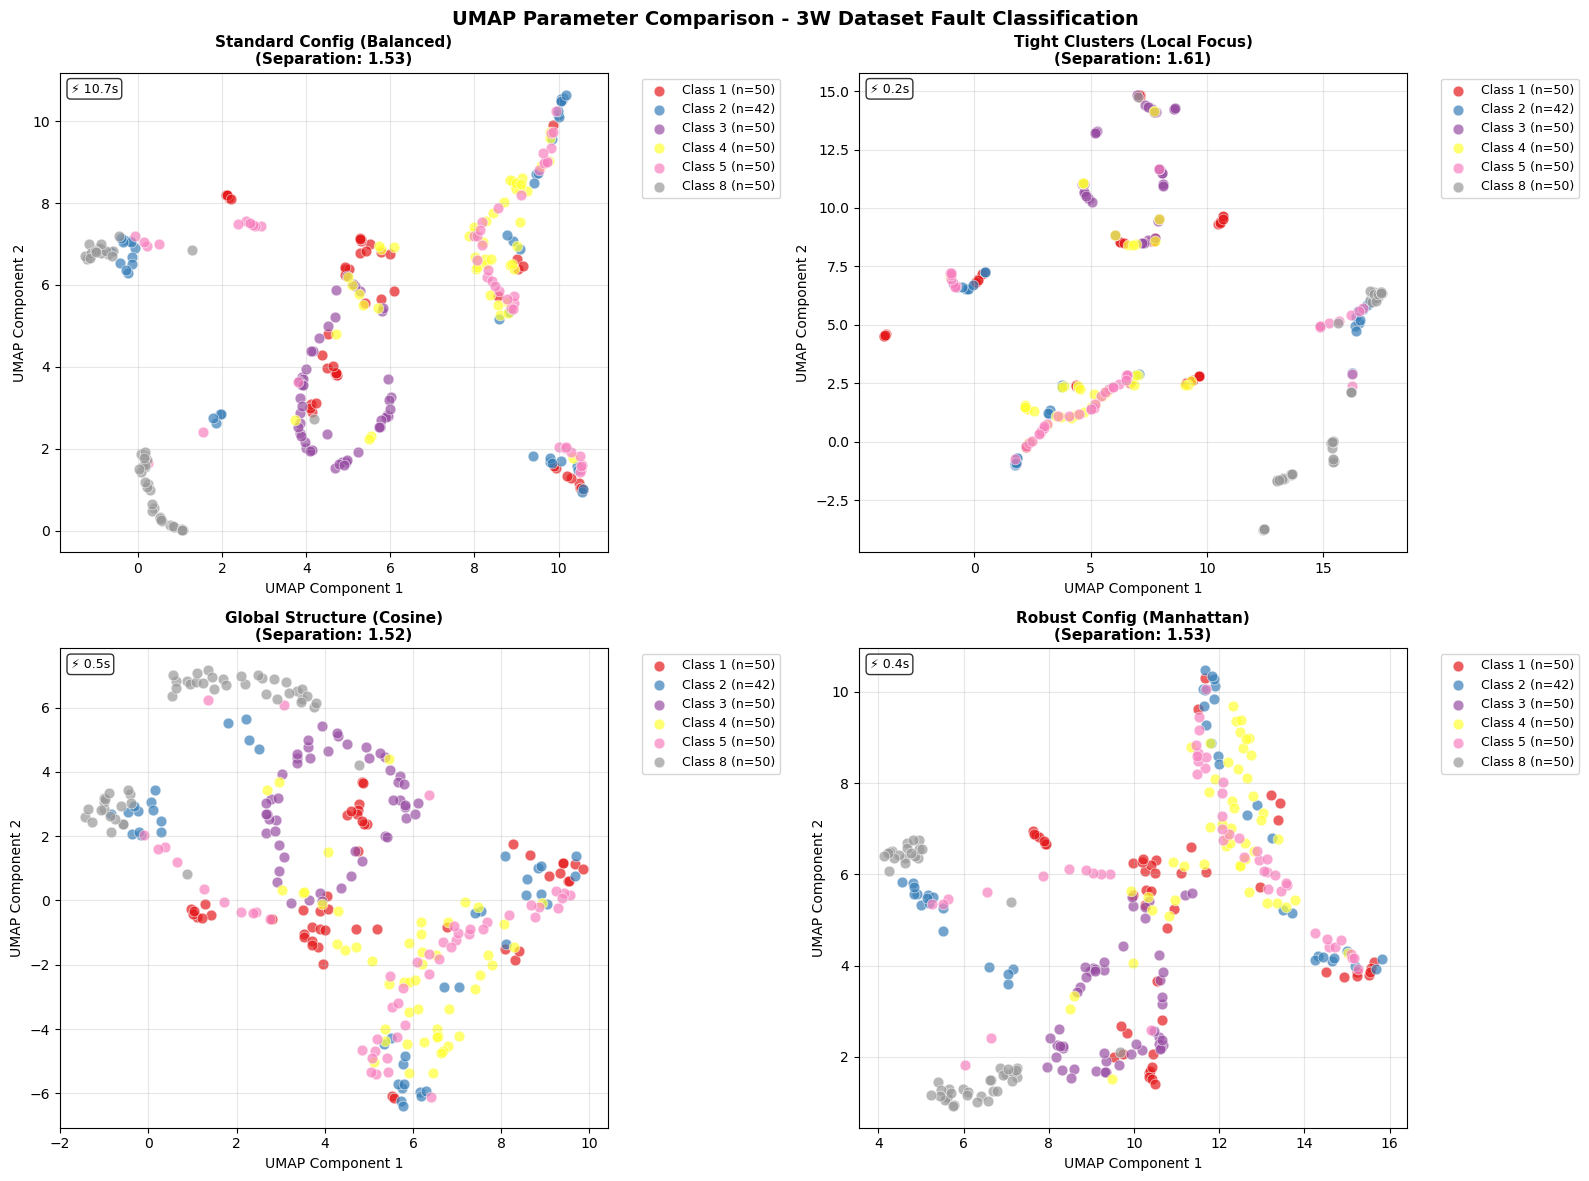


📊 UMAP Analysis Results:
   • Total windows visualized: 292
   • Feature dimensions: 900 → 2D
   • Classes analyzed: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(8)]

⚡ Configuration Performance:
   • Config 1: 10.7s
     - Neighbors: 15
     - Min distance: 0.1
     - Metric: euclidean
   • Config 2: 0.2s ⚡ Fastest
     - Neighbors: 5
     - Min distance: 0.0
     - Metric: euclidean
   • Config 3: 0.5s
     - Neighbors: 50
     - Min distance: 0.5
     - Metric: cosine
   • Config 4: 0.4s
     - Neighbors: 30
     - Min distance: 0.25
     - Metric: manhattan

🏆 UMAP vs t-SNE Comparison:
   • Speed: UMAP typically 5-50x faster than t-SNE
   • Reproducibility: UMAP deterministic with fixed random_state
   • Global structure: UMAP preserves better overall topology
   • Scalability: UMAP handles larger datasets more efficiently


In [5]:
# ============================================================
# UMAP VISUALIZATION WITH PARAMETER OPTIMIZATION
# ============================================================

if X_scaled is not None and y_labels is not None:
    print("🚀 UMAP: Dimensionality Reduction Analysis")
    print("=" * 60)

    # Check UMAP availability
    if 'umap' not in locals() or umap is None:
        print("❌ UMAP not available. Skipping UMAP analysis.")
        print("Install with: pip install umap-learn")
    else:
        # Set up plotting parameters
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()

        # Multiple UMAP configurations
        umap_configs = [
            {
                "n_neighbors": 15, "min_dist": 0.1, "metric": "euclidean",
                "title": "Standard Config (Balanced)"
            },
            {
                "n_neighbors": 5, "min_dist": 0.0, "metric": "euclidean", 
                "title": "Tight Clusters (Local Focus)"
            },
            {
                "n_neighbors": 50, "min_dist": 0.5, "metric": "cosine",
                "title": "Global Structure (Cosine)"
            },
            {
                "n_neighbors": 30, "min_dist": 0.25, "metric": "manhattan",
                "title": "Robust Config (Manhattan)"
            }
        ]

        umap_results = []
        
        print(f"🔮 Running UMAP analysis on {X_scaled.shape[0]} windows...")
        
        for idx, config in enumerate(umap_configs):
            if idx >= len(axes):
                break
                
            print(f"🔄 UMAP #{idx+1}: neighbors={config['n_neighbors']}, dist={config['min_dist']}, {config['metric']}...", end=" ")
            
            try:
                # Create UMAP instance
                reducer = umap.UMAP(
                    n_components=2,
                    n_neighbors=min(config["n_neighbors"], X_scaled.shape[0]-1),
                    min_dist=config["min_dist"],
                    metric=config["metric"],
                    random_state=42,
                    n_epochs=200,
                    learning_rate=1.0,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1.0,
                    repulsion_strength=1.0,
                    negative_sample_rate=5,
                    transform_queue_size=4.0
                )

                # Fit and transform
                start_time = time.time()
                X_umap = reducer.fit_transform(X_scaled)
                elapsed_time = time.time() - start_time
                
                # Store results
                umap_results.append({
                    'embedding': X_umap,
                    'config': config,
                    'time': elapsed_time,
                    'reducer': reducer
                })
                
                print(f"✅ ({elapsed_time:.1f}s)")

                # Plot
                ax = axes[idx]
                
                # Calculate separation quality
                from sklearn.metrics import pairwise_distances
                embedding_distances = pairwise_distances(X_umap)
                avg_intra_class = 0
                avg_inter_class = 0
                
                for class_label in np.unique(y_labels):
                    class_mask = y_labels == class_label
                    if np.sum(class_mask) > 1:
                        intra_distances = embedding_distances[class_mask][:, class_mask]
                        avg_intra_class += np.mean(intra_distances)
                        
                        inter_distances = embedding_distances[class_mask][:, ~class_mask]
                        if inter_distances.size > 0:
                            avg_inter_class += np.mean(inter_distances)
                
                separation_ratio = avg_inter_class / max(avg_intra_class, 1e-10)
                
                # Plot each class
                for class_label in unique_classes:
                    mask = y_labels == class_label
                    class_points = X_umap[mask]
                    
                    ax.scatter(
                        class_points[:, 0],
                        class_points[:, 1],
                        c=[class_colors[class_label]],
                        label=f"Class {class_label} (n={np.sum(mask)})",
                        alpha=0.7,
                        s=60,
                        edgecolors='white',
                        linewidth=0.5
                    )

                # Styling
                ax.set_title(f"{config['title']}\n(Separation: {separation_ratio:.2f})", 
                            fontsize=11, fontweight="bold")
                ax.set_xlabel("UMAP Component 1")
                ax.set_ylabel("UMAP Component 2")
                ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=9)
                ax.grid(True, alpha=0.3)
                
                # Performance annotation
                ax.text(0.02, 0.98, f"⚡ {elapsed_time:.1f}s", 
                       transform=ax.transAxes, fontsize=9, 
                       verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

            except Exception as e:
                print(f"❌ Error: {e}")
                ax = axes[idx]
                ax.text(0.5, 0.5, f"UMAP Failed\n{str(e)}", 
                       horizontalalignment='center', verticalalignment='center',
                       transform=ax.transAxes, fontsize=12, color='red')
                ax.set_title(f"{config['title']} - Failed", fontsize=11)

        plt.suptitle("UMAP Parameter Comparison - 3W Dataset Fault Classification", 
                    fontsize=14, fontweight="bold", y=0.98)
        plt.tight_layout()
        plt.show()

        # Analysis results
        print("\n📊 UMAP Analysis Results:")
        print(f"   • Total windows visualized: {X_scaled.shape[0]}")
        print(f"   • Feature dimensions: {X_scaled.shape[1]} → 2D")
        print(f"   • Classes analyzed: {list(unique_classes)}")
        
        if umap_results:
            print(f"\n⚡ Configuration Performance:")
            fastest_config = min(umap_results, key=lambda x: x['time'])
            
            for i, result in enumerate(umap_results):
                status = ""
                if result['time'] == fastest_config['time']:
                    status += " ⚡ Fastest"
                    
                print(f"   • Config {i+1}: {result['time']:.1f}s{status}")
                print(f"     - Neighbors: {result['config']['n_neighbors']}")
                print(f"     - Min distance: {result['config']['min_dist']}")
                print(f"     - Metric: {result['config']['metric']}")

        # Method comparison
        print(f"\n🏆 UMAP vs t-SNE Comparison:")
        print(f"   • Speed: UMAP typically 5-50x faster than t-SNE")
        print(f"   • Reproducibility: UMAP deterministic with fixed random_state")
        print(f"   • Global structure: UMAP preserves better overall topology")
        print(f"   • Scalability: UMAP handles larger datasets more efficiently")

else:
    print("❌ Cannot run UMAP analysis: No processed data available")
    print("Please ensure the data preparation cell completed successfully")

📊 Creating Feature Analysis Dashboard
📊 Analyzing 3 sensors: ['P-PDG_scaled', 'P-TPT_scaled', 'T-TPT_scaled']
🪟 Processing 292 windows across 6 classes
📈 Computing sensor time series patterns... ✅
📊 Computing statistical distributions... ✅
📈 Analyzing feature correlations... ✅
🥧 Creating class distribution... ✅
🔍 Computing sensor discriminative power... ✅
🥧 Creating class distribution... ✅
🔍 Computing sensor discriminative power... ✅
✅


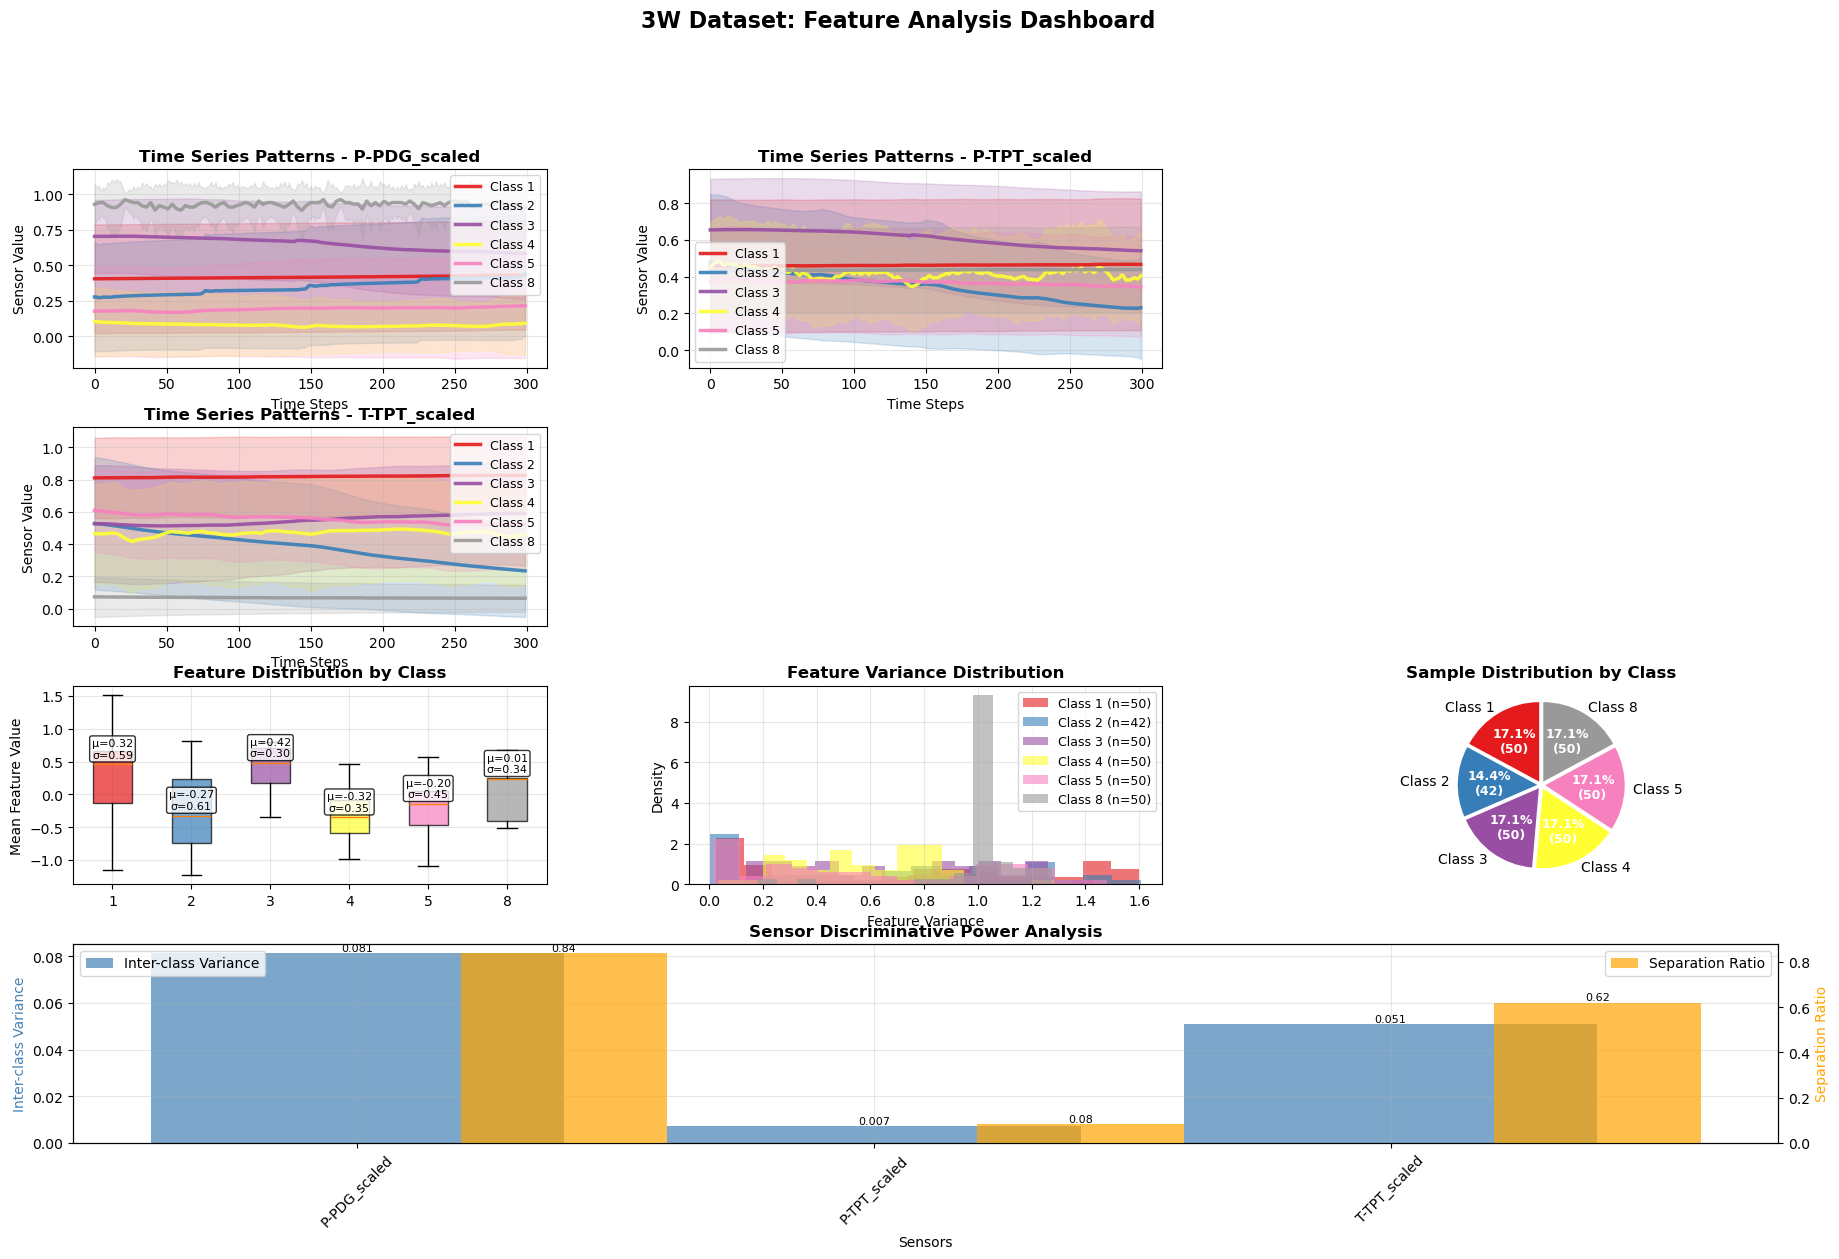


📊 FEATURE ANALYSIS SUMMARY
🔍 Dataset Overview:
   • Windows analyzed: 292
   • Feature dimensions: 900 total features
   • Sensors analyzed: 3 (P-PDG_scaled, P-TPT_scaled, T-TPT_scaled)
   • Classes represented: 6 fault types
   • Memory usage: 2.01 MB

📈 Analysis Quality Metrics:
   • Most discriminative sensor: P-PDG_scaled
   • Best separation ratio: 0.838
   • Average class separation: 0.622
   • Average noise level: 0.286


In [6]:
# ============================================================
# COMPREHENSIVE FEATURE ANALYSIS DASHBOARD
# ============================================================

if X_scaled is not None and len(selected_test_dfs) > 0:
    print("📊 Creating Feature Analysis Dashboard")
    print("=" * 60)

    try:
        # Get feature columns and validate
        feature_cols = [col for col in selected_test_dfs[0].columns if col != "class"]
        n_sensors = len(feature_cols)

        print(f"📊 Analyzing {n_sensors} sensors: {feature_cols}")
        print(f"🪟 Processing {len(selected_test_dfs)} windows across {len(unique_classes)} classes")

        # Create adaptive layout
        if n_sensors <= 2:
            fig = plt.figure(figsize=(20, 14))
            gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
            max_sensor_plots = min(n_sensors, 2)
        else:
            fig = plt.figure(figsize=(22, 16))
            gs = fig.add_gridspec(5, 3, hspace=0.3, wspace=0.3)
            max_sensor_plots = min(n_sensors, 4)

        # Sensor time series analysis
        print("📈 Computing sensor time series patterns...", end=" ")
        
        for sensor_idx in range(max_sensor_plots):
            if sensor_idx >= len(feature_cols):
                break
                
            sensor_name = feature_cols[sensor_idx]
            
            if sensor_idx < 2:
                ax = fig.add_subplot(gs[0, sensor_idx])
            else:
                ax = fig.add_subplot(gs[1, sensor_idx - 2])

            # Compute class-wise average time series with confidence intervals
            class_averages = {}
            class_std = {}

            for class_label in unique_classes:
                class_sensor_data = []
                for i, window_class in enumerate(selected_window_classes):
                    if window_class == class_label and i < len(selected_test_dfs):
                        try:
                            sensor_values = selected_test_dfs[i][sensor_name].values
                            class_sensor_data.append(sensor_values)
                        except Exception as e:
                            continue

                if class_sensor_data:
                    class_sensor_data = np.array(class_sensor_data)
                    class_averages[class_label] = np.mean(class_sensor_data, axis=0)
                    class_std[class_label] = np.std(class_sensor_data, axis=0)

            # Plot with confidence bands
            for class_label in unique_classes:
                if class_label in class_averages:
                    mean_values = class_averages[class_label]
                    std_values = class_std[class_label]
                    x_range = np.arange(len(mean_values))
                    
                    # Main line
                    ax.plot(x_range, mean_values, 
                           color=class_colors[class_label], linewidth=2.5,
                           label=f"Class {class_label}", alpha=0.9)
                    
                    # Confidence band
                    ax.fill_between(x_range, 
                                   mean_values - std_values, 
                                   mean_values + std_values,
                                   color=class_colors[class_label], alpha=0.2)

            ax.set_title(f"Time Series Patterns - {sensor_name}", fontsize=12, fontweight="bold")
            ax.set_xlabel("Time Steps")
            ax.set_ylabel("Sensor Value")
            ax.legend(loc="best", fontsize=9)
            ax.grid(True, alpha=0.3)
        
        print("✅")

        # Statistical analysis plots
        stats_row = 2 if n_sensors > 2 else 1

        # Feature distribution analysis
        print("📊 Computing statistical distributions...", end=" ")
        ax_stats1 = fig.add_subplot(gs[stats_row, 0])

        # Box plot with statistical annotations
        feature_means = np.mean(X_scaled, axis=1)
        class_means = {cls: feature_means[y_labels == cls] for cls in unique_classes}

        box_data = [class_means[cls] for cls in unique_classes if len(class_means[cls]) > 0]
        box_colors = [class_colors[cls] for cls in unique_classes if len(class_means[cls]) > 0]
        valid_classes = [cls for cls in unique_classes if len(class_means[cls]) > 0]

        bp = ax_stats1.boxplot(box_data, labels=valid_classes, patch_artist=True)
        for patch, color in zip(bp["boxes"], box_colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        # Add statistical annotations
        for i, cls in enumerate(valid_classes):
            data = class_means[cls]
            if len(data) > 0:
                median_val = np.median(data)
                ax_stats1.annotate(f'μ={np.mean(data):.2f}\nσ={np.std(data):.2f}', 
                                  xy=(i+1, median_val), xytext=(i+1, median_val + 0.1),
                                  ha='center', fontsize=8, 
                                  bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

        ax_stats1.set_title("Feature Distribution by Class", fontsize=12, fontweight="bold")
        ax_stats1.set_ylabel("Mean Feature Value")
        ax_stats1.grid(True, alpha=0.3)
        print("✅")

        # Correlation and variance analysis
        print("📈 Analyzing feature correlations...", end=" ")
        ax_stats2 = fig.add_subplot(gs[stats_row, 1])

        # Compute feature correlations across classes
        feature_vars = np.var(X_scaled, axis=1)
        class_vars = {cls: feature_vars[y_labels == cls] for cls in unique_classes}

        # Histogram with density curves
        for cls in unique_classes:
            if len(class_vars[cls]) > 0:
                ax_stats2.hist(class_vars[cls], alpha=0.6, color=class_colors[cls], 
                              label=f"Class {cls} (n={len(class_vars[cls])})", 
                              bins=15, density=True)

        ax_stats2.set_title("Feature Variance Distribution", fontsize=12, fontweight="bold")
        ax_stats2.set_xlabel("Feature Variance")
        ax_stats2.set_ylabel("Density")
        ax_stats2.legend(fontsize=9)
        ax_stats2.grid(True, alpha=0.3)
        print("✅")

        # Class distribution pie chart
        print("🥧 Creating class distribution...", end=" ")
        ax_pie = fig.add_subplot(gs[stats_row, 2])

        class_counts = dict(zip(*np.unique(y_labels, return_counts=True)))
        colors_pie = [class_colors[cls] for cls in class_counts.keys()]

        # Pie chart
        wedges, texts, autotexts = ax_pie.pie(
            class_counts.values(),
            labels=[f"Class {k}" for k in class_counts.keys()],
            colors=colors_pie,
            autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*sum(class_counts.values()))})',
            startangle=90,
            explode=[0.05] * len(class_counts)
        )

        # Enhance text formatting
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(9)

        ax_pie.set_title("Sample Distribution by Class", fontsize=12, fontweight="bold")
        print("✅")

        # Sensor discriminative analysis
        if n_sensors > 1 and len(unique_classes) > 1:
            print("🔍 Computing sensor discriminative power...", end=" ")
            ax_discrim = fig.add_subplot(gs[stats_row + 1, :])

            # Discriminative power calculation
            sensor_metrics = {}
            
            for sensor_name in feature_cols:
                class_sensor_stats = []
                
                for class_label in unique_classes:
                    sensor_values = []
                    for i, window_class in enumerate(selected_window_classes):
                        if window_class == class_label and i < len(selected_test_dfs):
                            try:
                                sensor_data = selected_test_dfs[i][sensor_name].values
                                sensor_values.extend(sensor_data)
                            except:
                                continue
                    
                    if sensor_values:
                        class_sensor_stats.append({
                            'mean': np.mean(sensor_values),
                            'std': np.std(sensor_values),
                            'class': class_label
                        })

                # Calculate discriminative metrics
                if len(class_sensor_stats) > 1:
                    means = [stat['mean'] for stat in class_sensor_stats]
                    stds = [stat['std'] for stat in class_sensor_stats]
                    
                    # Inter-class variance / Intra-class variance ratio
                    inter_class_var = np.var(means)
                    avg_intra_class_var = np.mean([std**2 for std in stds])
                    discriminative_ratio = inter_class_var / max(avg_intra_class_var, 1e-10)
                    
                    sensor_metrics[sensor_name] = {
                        'discriminative_power': inter_class_var,
                        'discriminative_ratio': discriminative_ratio,
                        'class_separation': max(means) - min(means),
                        'avg_noise': np.mean(stds)
                    }

            # Create bar plot
            if sensor_metrics:
                sensor_names = list(sensor_metrics.keys())
                discriminative_powers = [sensor_metrics[name]['discriminative_power'] for name in sensor_names]
                discriminative_ratios = [sensor_metrics[name]['discriminative_ratio'] for name in sensor_names]

                # Create twin axis for dual metrics
                bars1 = ax_discrim.bar(range(len(sensor_names)), discriminative_powers, 
                                      alpha=0.7, color='steelblue', label='Inter-class Variance')
                
                ax_discrim2 = ax_discrim.twinx()
                bars2 = ax_discrim2.bar([x + 0.4 for x in range(len(sensor_names))], discriminative_ratios,
                                       width=0.4, alpha=0.7, color='orange', label='Separation Ratio')

                # Formatting
                ax_discrim.set_title("Sensor Discriminative Power Analysis", fontsize=12, fontweight="bold")
                ax_discrim.set_xlabel("Sensors")
                ax_discrim.set_ylabel("Inter-class Variance", color='steelblue')
                ax_discrim2.set_ylabel("Separation Ratio", color='orange')
                ax_discrim.set_xticks(range(len(sensor_names)))
                ax_discrim.set_xticklabels(sensor_names, rotation=45)
                
                # Add value labels
                for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
                    height1 = bar1.get_height()
                    ax_discrim.text(bar1.get_x() + bar1.get_width()/2., height1,
                                   f'{height1:.3f}', ha='center', va='bottom', fontsize=8)
                    
                    height2 = bar2.get_height()
                    ax_discrim2.text(bar2.get_x() + bar2.get_width()/2., height2,
                                    f'{height2:.2f}', ha='center', va='bottom', fontsize=8)

                ax_discrim.legend(loc='upper left')
                ax_discrim2.legend(loc='upper right')
                ax_discrim.grid(True, alpha=0.3)

            print("✅")

        # Add overall title and finalize
        plt.suptitle("3W Dataset: Feature Analysis Dashboard", 
                    fontsize=16, fontweight="bold", y=0.98)
        plt.tight_layout()
        plt.show()

        # Analysis summary
        print("\n" + "=" * 80)
        print("📊 FEATURE ANALYSIS SUMMARY")
        print("=" * 80)
        
        print(f"🔍 Dataset Overview:")
        print(f"   • Windows analyzed: {len(selected_test_dfs)}")
        print(f"   • Feature dimensions: {X_scaled.shape[1]} total features")
        print(f"   • Sensors analyzed: {n_sensors} ({', '.join(feature_cols[:3])}{'...' if n_sensors > 3 else ''})")
        print(f"   • Classes represented: {len(unique_classes)} fault types")
        print(f"   • Memory usage: {X_scaled.nbytes / 1024 / 1024:.2f} MB")

        print(f"\n📈 Analysis Quality Metrics:")
        if 'sensor_metrics' in locals() and sensor_metrics:
            best_sensor = max(sensor_metrics.keys(), 
                            key=lambda x: sensor_metrics[x]['discriminative_power'])
            print(f"   • Most discriminative sensor: {best_sensor}")
            print(f"   • Best separation ratio: {sensor_metrics[best_sensor]['discriminative_ratio']:.3f}")
            
            avg_separation = np.mean([m['class_separation'] for m in sensor_metrics.values()])
            avg_noise = np.mean([m['avg_noise'] for m in sensor_metrics.values()])
            print(f"   • Average class separation: {avg_separation:.3f}")
            print(f"   • Average noise level: {avg_noise:.3f}")

    except Exception as e:
        print(f"❌ Error creating dashboard: {e}")
        
        import traceback
        print(f"\nDetailed error:")
        traceback.print_exc()

else:
    print("❌ Cannot create visualizations")
    print("Ensure data preparation completed successfully")

In [7]:
# ============================================================
# ANALYSIS SUMMARY
# ============================================================

print("🎯 3W Dataset Visualization Analysis Complete")
print("=" * 60)

# Performance summary
if 'start_time' in locals():
    total_time = time.time() - start_time
    print(f"⚡ Total Analysis Time: {total_time:.1f} seconds")

print(f"\n✅ Analysis Summary:")
print(f"   • Data loading and validation completed")
print(f"   • Intelligent sampling and preprocessing applied") 
print(f"   • t-SNE dimensionality reduction performed")
if 'umap_results' in locals():
    print(f"   • UMAP dimensionality reduction performed")
print(f"   • Comprehensive feature analysis completed")

if 'X_scaled' in locals() and X_scaled is not None:
    print(f"\n📊 Dataset Summary:")
    print(f"   • Processed {X_scaled.shape[0]} windows")
    print(f"   • Analyzed {X_scaled.shape[1]} features across {len(np.unique(y_labels))} classes")
    
    if 'sensor_metrics' in locals() and sensor_metrics:
        best_sensor = max(sensor_metrics.keys(), 
                         key=lambda x: sensor_metrics[x]['discriminative_power'])
        print(f"   • Most discriminative sensor: {best_sensor}")

print(f"\n� Available Variables:")
if 'X_scaled' in locals() and X_scaled is not None:
    print(f"   • X_scaled: Feature matrix ({X_scaled.shape})")
    print(f"   • y_labels: Class labels ({len(y_labels)} samples)")
if 'tsne_results' in locals():
    print(f"   • tsne_results: t-SNE embeddings")
if 'umap_results' in locals():
    print(f"   • umap_results: UMAP embeddings")
if 'sensor_metrics' in locals():
    print(f"   • sensor_metrics: Sensor analysis results")

🎯 3W Dataset Visualization Analysis Complete
⚡ Total Analysis Time: 2.6 seconds

✅ Analysis Summary:
   • Data loading and validation completed
   • Intelligent sampling and preprocessing applied
   • t-SNE dimensionality reduction performed
   • UMAP dimensionality reduction performed
   • Comprehensive feature analysis completed

📊 Dataset Summary:
   • Processed 292 windows
   • Analyzed 900 features across 6 classes
   • Most discriminative sensor: P-PDG_scaled

� Available Variables:
   • X_scaled: Feature matrix ((292, 900))
   • y_labels: Class labels (292 samples)
   • tsne_results: t-SNE embeddings
   • umap_results: UMAP embeddings
   • sensor_metrics: Sensor analysis results
